## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to be applied on STM32 Nucleo Board.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
%cd gdrive/

/content/gdrive


In [3]:
%cd MyDrive/

/content/gdrive/MyDrive


In [4]:
%cd Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/


/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]


In [5]:
%cd Scripts/

/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts


In [6]:
%cd Project/

/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project


In [7]:
%ls

Active_Model.ipynb      Frozen_Model.ipynb  Results/
Active_Model_Zat.ipynb  lib/                Saved_models/


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import sys
import csv 
import tempfile

import torchvision.models as models
from torchvision import transforms

ROOT_PATH = os.path.abspath('')
sys.path.insert(0, ROOT_PATH + '/lib')
from simulation_lib import *

Load MNIST dataset and split in training and test

In [9]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

11490434/11490434 [==============================] - 0s 0us/step
The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [10]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples = np.sum(np.where(label_test <  6, 1, 0))

# separate in containers data that is lower nad higer than 6
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i]<6):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1
    else:
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (6031, 28, 28)
     Test dataset higher than 6 has shape: (3969, 28, 28)


9
6.0


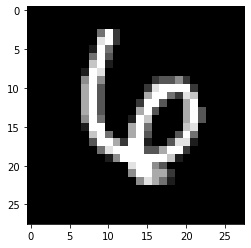

In [11]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,20))
print(num)
plt.imshow(data_high_test[num], cmap="gray") # Import the image
print(label_high_test[num])
plt.show() # Plot the image

## **Pre process the data**

In [12]:
# Image dimensions
img_rows, img_cols = 28, 28

In [13]:
# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape     = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape     = (img_rows, img_cols, 1)

Normalize the dataset

In [14]:
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **BUILD THE MODEL**

In [15]:
TRAIN_MODEL_1 = True
TRAIN_MODEL_2 = False
TRAIN_MODEL_3 = False
TRAIN_MODEL_4 = False

In [16]:
batch_size = 32
epochs     = 40
validation_split = 0.1
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [17]:
if(False):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(6, activation = "softmax"))

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()

In [18]:
if(TRAIN_MODEL_1):
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6,activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

In [19]:
#if(TRAIN_MODEL_1):
    #tf.keras.utils.plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [20]:
# METHOD 2
# This model is a bit larger and should be much more precise in the feature extraction
if(TRAIN_MODEL_2):
    model2 = Sequential()
    model2.add(Conv2D(32, (3, 3), input_shape = input_shape))
    model2.add(Conv2D(32, (3, 3), activation = "relu"))
    model2.add(MaxPooling2D(pool_size = (2, 2)))
    model2.add(Dropout(0.2))
    model2.add(Flatten())
    model2.add(Dense(128, activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(6, activation = "softmax"))

    model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model2.summary()

In [21]:
if(TRAIN_MODEL_3):

    l = tf.keras.layers # syntax shortcut

    def fire(x, squeeze, expand):
        y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
        y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
        y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
        return tf.keras.layers.concatenate([y1, y3])

    # this is to make it behave similarly to other Keras layers
    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    # usage:
    x = tf.keras.layers.Input(shape=[*input_shape]) # input is 192x192 pixels RGB

    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(6, activation='softmax')(y)

    model3 = tf.keras.Model(x, y)
    model3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model3.summary()

In [22]:
if(TRAIN_MODEL_4):
    model4 = Sequential()
    
    model4.add(Conv2D(8, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model4.add(Conv2D(8, (3,3), activation='relu'))
    model4.add(MaxPooling2D(pool_size=(2,2)))
    
    model4.add(Conv2D(32, (3,3), activation='relu'))
    model4.add(Conv2D(32, (3,3), activation='relu'))
    model4.add(MaxPooling2D(pool_size=(2,2)))


    model4.add(Dropout(0.25))
    model4.add(Flatten())
    model4.add(Dense(512,activation='relu'))
    model4.add(Dense(6,activation='softmax'))

    model4.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())

## TRAIN THE MODEL

In [23]:
if(TRAIN_MODEL_1):
    
    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    train_hist = model.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)
    
  # Evaluate the model performance
    test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1013/1013 [==============================] - 18s 8ms/step - loss: 0.1606 - accuracy: 0.9474 - val_loss: 0.0417 - val_accuracy: 0.9895
Epoch 2/40
1013/1013 [==============================] - 7s 7ms/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.0344 - val_accuracy: 0.9911
Epoch 3/40
1013/1013 [==============================] - 7s 7ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.0273 - val_accuracy: 0.9931
Epoch 4/40
1013/1013 [==============================] - 7s 7ms/step - loss: 0.0223 - accuracy: 0.9932 - val_loss: 0.0251 - val_accuracy: 0.9933
Epoch 5/40
1013/1013 [==============================] - 7s 7ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0211 - val_accuracy: 0.9956
Epoch 6/40
1013/1013 [==============================] - 7s 7ms/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.0172 - val_accuracy: 0.9958
Epoch 7/40
1013/1013 [==============================] - 7s 7ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0229 - val_accuracy: 0.9953
Ep

In [24]:
if(TRAIN_MODEL_2):

    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    model2.fit(data_low_train, labels_prova, epochs = epochs, batch_size = batch_size, validation_split = validation_split )

    # Evaluate the model performance
    test_loss, test_acc = model2.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [25]:
if(TRAIN_MODEL_3):
    
    labels_modified_test = keras.utils.to_categorical(label_low_train, 6)
    
    model3.fit(data_low_train, labels_modified_test, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

    # Evaluate the model performance
    test_loss, test_acc = model3.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [ ]:
if(TRAIN_MODEL_4):
    
    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    train_hist = model4.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)
    
  # Evaluate the model performance
    test_loss, test_acc = model4.evaluate(data_low_test, label_low_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

## TEST THE MODEL

In [27]:
def hostiry_training_plot(model):
    hist_loss     = model.history['loss']
    hist_val_loss = model.history['val_loss']
    hist_acc      = train_hist.history['accuracy']
    hist_val_acc  = train_hist.history['val_accuracy']
    epoch_list    = list(range(epochs))
   
    plt.subplot(211)
    plt.plot(epoch_list, hist_acc,  label='Accuracy', linewidth=3)
    plt.plot(epoch_list, hist_val_acc,  label='Validation accuracy', linewidth=3)
    plt.legend(prop={'size': 17})
    plt.xlabel('Epochs',  fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    plt.subplot(212)
    plt.plot(epoch_list, hist_loss, 'bo', label='Training loss', linewidth=3)
    plt.plot(epoch_list, hist_val_loss, 'r', label='Validation loss', linewidth=3)
    plt.legend(prop={'size': 17})
    plt.xlabel('Epochs',  fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    ROOT_PATH = os.path.abspath('')
    PLOT_PATH = ROOT_PATH + "/Results/"
    plt.savefig(PLOT_PATH + 'training_History.jpg')
    plt.show()

function for generating a bar plot htat shows the accuracy of the model for each class

In [28]:
def plot_ConfusionMatrix(conf_matrix):

    figure = plt.figure()
    axes = figure.add_subplot()

    label = ['0','1','2','3','4','5']

    caxes = axes.matshow(conf_matrix, cmap=plt.cm.Blues)
    figure.colorbar(caxes)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            axes.text(x=j, y=i,s=int(conf_matrix[i, j]), va='center', ha='center', size='large')

    axes.xaxis.set_ticks_position("bottom")
    axes.set_xticklabels([''] + label)
    axes.set_yticklabels([''] + label)

    plt.xlabel('PREDICTED LABEL', fontsize=15)
    plt.ylabel('TRUE LABEL', fontsize=15)
    ROOT_PATH = os.path.abspath('')
    PLOT_PATH = ROOT_PATH + "/Results/"
    plt.savefig(PLOT_PATH + 'training_ConfMatrix.jpg')
    plt.show()

In [29]:
def testing(data, label_lett, model):

    conf_matrix = np.zeros((6,6))

    prediction = model.predict(data)
    
    for i in range(0, data.shape[0]):

        # Find the max iter for both true label and prediction
        max_i_true = int(label_lett[i])

        max_i_pred = np.argmax(prediction[i,:])

        conf_matrix[max_i_true, max_i_pred] = conf_matrix[max_i_true, max_i_pred] + 1

    return conf_matrix

In [30]:
def plot_Accuracy(conf_matrix):
                        
    tot_cntr = 0
    correct_cntr = 0

    corr_ary   = np.zeros(6)
    tot_ary    = np.zeros(6)
    bar_values = np.zeros(7) 

    letter_labels = ['0','1','2','3','4','5','Model']
    blue2 = 'cornflowerblue'
    colors = [blue2, blue2, blue2, blue2, blue2, blue2, 'steelblue']

    for i in range(0, conf_matrix.shape[0]):
        bar_values[i] = round(round(conf_matrix[i,i]/ sum(conf_matrix[i,:]), 4)*100,2)
        tot_cntr += sum(conf_matrix[i,:])
        correct_cntr += conf_matrix[i,i]

    bar_values[-1] = round(round(correct_cntr/tot_cntr, 4)*100,2)
    

    fig = plt.subplots(figsize =(10, 6))

    bar_plot = plt.bar(letter_labels, bar_values, color=colors, edgecolor='grey')

    for p in bar_plot:
        height = p.get_height()
        xy_pos = (p.get_x() + p.get_width() / 2, 105)

        plt.annotate(str(height) + '%', xy=xy_pos, xytext=(0, 0), textcoords="offset points", ha='center', va='bottom', fontsize=15,  fontweight ='bold')

    plt.axhline(y = 100, color = 'gray', linestyle = (0, (5, 10)) ) # Grey line at 100 %

    # Text and labels
    ROOT_PATH = os.path.abspath('')
    PLOT_PATH = ROOT_PATH + "/Results/"
    plt.ylim([0, 119])
    plt.ylabel('Accuracy %', fontsize = 20)
    plt.yticks(fontsize = 15)
    plt.xticks([r for r in range(len(letter_labels))], letter_labels, fontweight ='bold', fontsize = 15) # Write on x axis the letter name
    plt.savefig(PLOT_PATH + 'training_Test.jpg')
    plt.show()

    print(f"Total correct guesses  {sum(corr_ary)}  -> {round(round(sum(corr_ary)/sum(tot_ary), 4)*100,2)}%")


In [31]:
def plot_Table(conf_matrix):

    table_values = np.zeros([3,conf_matrix.shape[0]])

    for i in range(0, table_values.shape[1]):

        if(sum(conf_matrix[i,:])==0):   # if for avoiding division by 0 that generates NAN                                
            table_values[0,i] = 0
        else:
            table_values[0,i] = round(conf_matrix[i,i]/sum(conf_matrix[i,:]),2)      # ACCURACY

        if(sum(conf_matrix[:,i])==0):   # if for avoiding division by 0 that generates NAN
            table_values[1,i] = 0
        else:
            table_values[1,i] = round(conf_matrix[i,i]/sum(conf_matrix[:,i]),2)      # PRECISION 

        if((table_values[1,i]+table_values[0,i])==0):     # if for avoiding division by 0 that generates NAN
            table_values[2,i] = 0
        else:
            table_values[2,i] = round((2*table_values[1,i]*table_values[0,i])/(table_values[1,i]+table_values[0,i]),2)    # F1 SCORE

    
    fig, ax = plt.subplots(figsize=(6,4)) 
    ax.set_axis_off() 
    
    table = ax.table( 
        cellText = table_values,  
        rowLabels = ['Accuracy', 'Precision', 'F1 score'],  
        colLabels = ['0','1','2','3','4','5'], 
        rowColours =["cornflowerblue"] * 200,  
        colColours =["cornflowerblue"] * 200, 
        rowLoc='right',
        loc ='center')   

    table.set_fontsize(14)
    ROOT_PATH = os.path.abspath('')
    PLOT_PATH = ROOT_PATH + "/Results/"
    plt.savefig(PLOT_PATH + 'training_Table.jpg')
    plt.show()

189/189 [==============================] - 1s 3ms/step


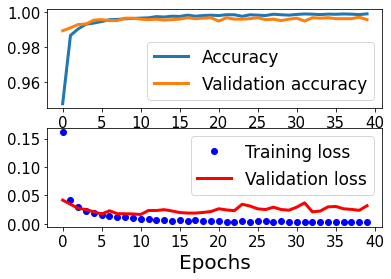

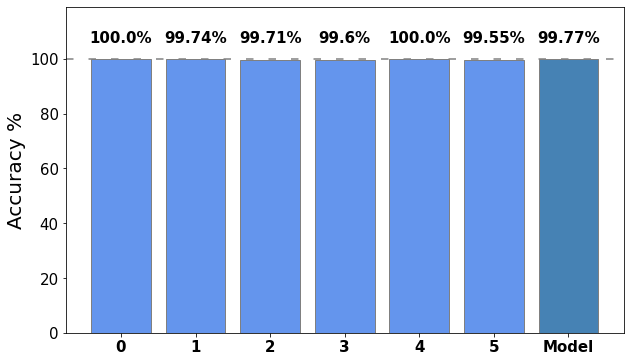

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


Total correct guesses  0.0  -> nan%


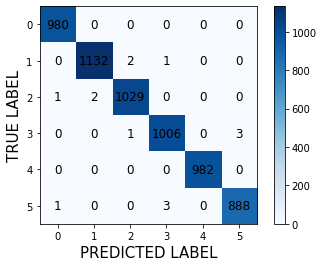

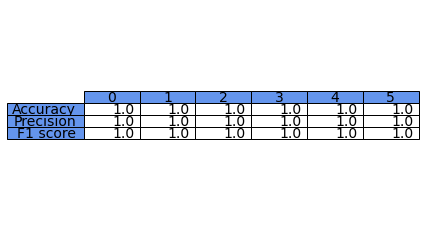

In [32]:
confusion_matrix = testing(data_low_test, label_low_test, model)
hostiry_training_plot(train_hist)
plot_Accuracy(confusion_matrix)
plot_ConfusionMatrix(confusion_matrix)
plot_Table(confusion_matrix)

In [33]:
if(TRAIN_MODEL_1):
    model_test = model
elif(TRAIN_MODEL_2):
    model_test = model2
elif(TRAIN_MODEL_3):
    model_test = model3
elif(TRAIN_MODEL_4):
    model_test = model4

In [34]:
predictions = model_test.predict(data_low_test)   # Make prediction of entire dataset

189/189 [==============================] - 1s 3ms/step


In [35]:
num = int(random.uniform(0,data_low_test.shape[0]))
print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , label_low_test[num])

Prediction =  1
True label =  1.0


In [36]:
def plot_image(i, predictions_array, true_label, img):
    class_names = ['0','1','2','3','4','5']

    true_label, img = int(true_label[i]), img[i,:,:]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = (np.squeeze(img))## you have to delete the channel information (if grayscale) to plot the image
    plt.imshow(img, cmap="gray")

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)   


def plot_value_array(i, predictions_array, true_label):
    true_label = int(true_label[i])
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

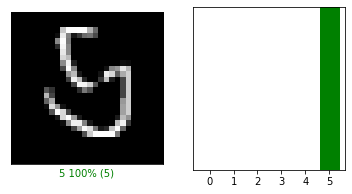

In [37]:
num = int(random.uniform(0, predictions.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

## **SAVE ORIGINAL MODELS**

In [38]:
def save_summary_model(model, MODEL_PATH, flag):
      with open(MODEL_PATH + 'model_summary.txt', "w") as new_file:

        new_file.write("PARAMETERS SAVED FROM THE TRAINING")
        if(flag==0):
           new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the ORIGINAL MODEL")
        elif(flag==1):
          new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the FROZEN MODEL")
        new_file.write("\n")
        new_file.write("\n Batch size:       " + str(batch_size))
        new_file.write("\n Epochs:           " + str(epochs))
        new_file.write("\n Metrics:          " + str(metrics))
        new_file.write("\n Optimizer:        " + optimizer)
        new_file.write("\n Loss:             " + "SparseCategoricalCrossentropy \n\n")

        model.summary(print_fn=lambda x: new_file.write(x + '\n'))
      new_file.close()

### SAVE ORIGINAL MODEL

In [39]:
ROOT_PATH = os.path.abspath('')
SAVE_MODEL_PATH = ROOT_PATH + "/Saved_models"

ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "/Original_model" 

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as Mnist_original_cnn.h5')
model_test.save(ORIGINAL_MODEL_PATH + "/Mnist_original_cnn.h5")
save_summary_model(model_test, ORIGINAL_MODEL_PATH+ "/Original_" , 0)

Test loss: 0.011182255111634731
Test accuracy: 0.9976786375045776
Save ORIGINAL MODEL as Mnist_original_cnn.h5


### SAVE ORIGINAL FROZEN MODEL

In [40]:
# CREATE AND SAVE THE FROZEN MODEL
frozen_model = keras.models.Sequential(model_test.layers[:-1])
frozen_model.summary()
frozen_model.compile()

FROZEN_ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_original_model"

print('Save FROZEN MODEL model as Mnist_frozen_original_cnn.h5')
frozen_model.save(FROZEN_ORIGINAL_MODEL_PATH + "/Mnist_frozen_original_cnn.h5")
save_summary_model(frozen_model, FROZEN_ORIGINAL_MODEL_PATH + "/Frozen_original_" , 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

In [41]:
ll_weights = np.array(model_test.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_test.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_ORIGINAL_MODEL_PATH + '/Original_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_ORIGINAL_MODEL_PATH + '/Original_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (512, 6)
The shape of the last layer biases is: (6,)


# Pruning

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

### PRUNING

In [42]:
pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 5.0 MB/s 


In [43]:
# Install needed optimization toolkit
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot

In [44]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after n epochs.
batch_size = 32
epochs = 5
validation_split = 0.1  # 10% of training set will be used for validation set. 

num_images = data_low_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model_test, **pruning_params)

# `prune_low_magnitude` requires a recompile.

# Select appropriate optimizer
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

In [45]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(data_low_train, label_low_train,
                    batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)

Epoch 1/5
   5/1013 [..............................] - ETA: 26s - loss: 4.2509e-06 - accuracy: 1.0000

1013/1013 [==============================] - 33s 24ms/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.0201 - val_accuracy: 0.9956
Epoch 2/5
1013/1013 [==============================] - 18s 18ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0160 - val_accuracy: 0.9947
Epoch 3/5
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0166 - val_accuracy: 0.9961
Epoch 4/5
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.0163 - val_accuracy: 0.9958
Epoch 5/5
1013/1013 [==============================] - 11s 11ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0164 - val_accuracy: 0.9969


In [46]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(data_low_test, label_low_test, verbose=0)

print('Original test accuracy: ', test_acc)
print('Pruned test accuracy:   ', model_for_pruning_accuracy)

Original test accuracy:  0.9976786375045776
Pruned test accuracy:    0.997181236743927


# SAVE PRUNED MODELS

In [47]:
def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

## SAVE PRUNED MODEL

In [48]:
# First, create a compressible model for TensorFlow

PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "/Pruned_model"


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save(PRUNED_MODEL_PATH + '/Mnist_pruned_cnn.h5', include_optimizer=False)
save_summary_model(model_for_export, PRUNED_MODEL_PATH + "/Pruned_" , 0)

In [49]:
# Then, create a compressible model for TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

with open(PRUNED_MODEL_PATH + '/Mnist_pruned_cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_model)

In [50]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(ORIGINAL_MODEL_PATH + '/Mnist_original_cnn.h5')))
print("Size of gzipped pruned Keras model  : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + '/Mnist_pruned_cnn.h5')))
print("Size of gzipped pruned TFlite model : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + '/Mnist_pruned_cnn.tflite')))

Size of gzipped baseline Keras model: 177124.00 bytes
Size of gzipped pruned Keras model  : 21556.00 bytes
Size of gzipped pruned TFlite model : 20106.00 bytes


## SAVE PRUNED AND QUANTIZED MODEL

https://www.tensorflow.org/lite/performance/post_training_quantization

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export) # load the converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.h5')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model             : %.2f bytes" % (get_gzipped_model_size(ORIGINAL_MODEL_PATH + "/Mnist_original_cnn.h5")))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Saved quantized and pruned TFLite model to: /tmp/tmpmvb8mhh9.h5
Size of gzipped baseline Keras model             : 177124.00 bytes
Size of gzipped pruned and quantized TFlite model: 8392.00 bytes


## SAVE PRUNED FORZEN MODEL

In [52]:
frozen_pruned_model = keras.models.Sequential(model_for_pruning.layers[:-1])
frozen_pruned_model.summary()
frozen_pruned_model.compile()

FROZEN_PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_pruned_model"

print('Save FROZEN PRUNED MODEL model as Mnist_frozen_pruned_cnn.h5')
frozen_pruned_model.save(FROZEN_PRUNED_MODEL_PATH + "/Mnist_frozen_pruned_cnn.h5")
save_summary_model(frozen_pruned_model, FROZEN_PRUNED_MODEL_PATH + "/Frozen_pruned_", 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 8)        154       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 24, 24, 8)        1162      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 12, 12, 8)        1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 10, 10, 32)       4642      
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 8, 8, 32)        

In [53]:
frozen_model_for_export = tfmot.sparsity.keras.strip_pruning(frozen_pruned_model)
frozen_model_for_export.save(FROZEN_PRUNED_MODEL_PATH + '/Mnist_frozen_pruned_cnn.h5', include_optimizer=False)

converter = tf.lite.TFLiteConverter.from_keras_model(frozen_model_for_export)
pruned_tflite_fmodel = converter.convert()

with open(FROZEN_PRUNED_MODEL_PATH + '/Mnist_frozen_pruned__cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_fmodel)

In [54]:
ll_pruned_weights = np.array(model_for_pruning.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_pruned_biases  = np.array(model_for_pruning.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_pruned_weights.shape}')
print(f'The shape of the last layer biases is: {ll_pruned_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_PRUNED_MODEL_PATH + '/Pruned_weights.txt', 'w') as new_file:

    for j in range(0, ll_pruned_weights.shape[1]):
        for i in range(0, ll_pruned_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_pruned_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_pruned_weights[i,j]))
            
            if(i == ll_pruned_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_PRUNED_MODEL_PATH + '/Pruned_biases.txt', 'w') as new_file:

    for i in range(0, ll_pruned_biases.shape[0]):     
        new_file.write(str(ll_pruned_biases[i])) 
        if(i!=ll_pruned_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (512, 6)
The shape of the last layer biases is: (6,)


# FEATURE EXTRACTION FOR CLUSTERING

In [55]:
n_samples = 50
digits_test = np.zeros((n_samples*10,28,28))
label_digits_test = np.zeros(n_samples*10)

j = 0
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0

for i in range(0,test_samples):
    if(label_test[i]==0 and count_0<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_0+=1
        j += 1
    if(label_test[i]==1 and count_1<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_1+=1
        j += 1
    if(label_test[i]==2 and count_2<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_2+=1
        j += 1
    if(label_test[i]==3 and count_3<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_3+=1
        j += 1
    if(label_test[i]==4 and count_4<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_4+=1
        j += 1
    if(label_test[i]==5 and count_5<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_5+=1
        j += 1
    if(label_test[i]==6 and count_6<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_6+=1
        j += 1
    if(label_test[i]==7 and count_7<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_7+=1
        j += 1
    if(label_test[i]==8 and count_8<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_8+=1
        j += 1
    if(label_test[i]==9 and count_9<n_samples):
        digits_test[j,:,:] = data_test[i,:,:]
        label_digits_test[j]    = label_test[i]
        count_9+=1
        j += 1

if K.image_data_format() == 'channels_first':
    digits_test = digits_test.reshape(digits_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    digits_test = digits_test.reshape(digits_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

digits_test = digits_test.astype(np.float32) / 255.0

In [56]:
print(f'The dataset on which the model will be TESTED has shape  {digits_test.shape}') # da cambiare con il nuovo set

The dataset on which the model will be TESTED has shape  (500, 28, 28, 1)


In [57]:
n_samples = str(n_samples)

## SAVE PRUNED FEATURES

In [58]:
np.savetxt(PRUNED_MODEL_PATH +'/Labels_pruned_features_'+n_samples+'.txt',label_digits_test, fmt='%1d')

In [59]:
frozen_features = frozen_pruned_model.predict(digits_test)
np.savetxt(PRUNED_MODEL_PATH +'/Pruned_features_'+n_samples+'.txt', frozen_features, fmt='%.3f')

16/16 [==============================] - 0s 9ms/step


In [60]:
with open(PRUNED_MODEL_PATH +'/Pruned_features_'+n_samples+'.txt', 'w') as new_file:

    for i in range(0, frozen_features.shape[0]):
        for j in range(0, frozen_features.shape[1]): 
            if frozen_features[i,j] != 0:
              str1 = '%.3f '%frozen_features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)
            
        new_file.write('\n')     

new_file.close()

## SAVE ORIGINAL FEATURES

In [61]:
np.savetxt(ORIGINAL_MODEL_PATH +'/Labels_original_features_'+n_samples+'.txt',label_digits_test, fmt='%1d')

In [62]:
original_features = frozen_model.predict(digits_test)
np.savetxt(ORIGINAL_MODEL_PATH +'/Original_features_'+n_samples+'.txt', original_features, fmt='%.3f')

16/16 [==============================] - 0s 4ms/step


In [63]:
with open(ORIGINAL_MODEL_PATH +'/Original_features_'+n_samples+'.txt', 'w') as new_file:

    for i in range(0, original_features.shape[0]):
        for j in range(0, original_features.shape[1]): 
            if original_features[i,j] != 0:
              str1 = '%.3f '%original_features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)
            
        new_file.write('\n')     

new_file.close()